# Coursework

## Before you begin

Every student has a slightly different assignment. To generate your personal
assignment you should first execute every cell in this Jupyter notebook (which you can do by clicking Validate).
You must then answer the questions given in the notebook.

The first cell in this Notebook generates your question for you.

You must complete this assignment by editing the Jupyter notebook distributed to you in your Assignments folder on CoCalc.

The Jupyter notebook containing your work will be automatically collected after the submission deadline. You should also upload a pdf of your notebook to Keats to the submission section under weeek 6.

The coursework is out of 100 marks.



In [3]:
import pandas
import numpy as np
from math import *
import coursework1lib
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import comb


question = coursework1lib.Question()


## Reading stock price data from a file

The file `stock-data.csv` contains weekly historic stock prices for two companies _ACME_ and _Big Bank_. All prices are in dollars. At each historic time point $t$,
you can represent the stock prices as a vector ${\mathbf S}_t$ whose first component is the price of _ACME_ and whose second component
is the price of _Big Bank_. The logs of the stock prices can similarly be represented as a vector $\mathbf{Z}_t$. Let $\delta t=\frac{1}{52}$ be the time
interval of 1 week \(so for the purposes of this question 1 year contains exactly 52 weeks and we are using the
financial convention of using the year as our unit of time\). Write $(\delta \mathbf{Z})_t=\mathbf{Z}_{t+\delta t}-\mathbf{Z}_t$.

Read the file `stock-data.csv` into Python and use this to do the following:

- Create a matrix called `dZ` with $N-1$ rows and $2$ columns containing all the weekly changes in the log stock price. Here $N$ is the number of weeks in the sample.
- Create a vector called `final` with $2$ columns containing the final stock prices.
- The sample average value of the vector $(\delta \mathbf{Z})_t$. Store the value as a `numpy` 2\-vector in a variable `m`. We will refer to this vector in the mathematics below as $\bm{m}$.
- The sample covariance matrix for the change $(\delta \mathbf{Z})_t$. Store the value as a `numpy` array in a variable `Sigma`. We will refer to this matrix in the mathematics below as $\Sigma$.

We have not seen how to read a `csv` file in the course. You can do this using `pandas.read_csv`, or you can use Excel to save the file in the Excel format that we have seen how to read, or you can use the Python library `csv`, or you could use some other approach. It is entirely up to you.



In [4]:
import pandas as pd
import numpy as np

data = pd.read_csv('stock-data.csv', header = 0, index_col = 0)
prices = data.values

#1
log_prices = np.log(prices)
dZ = np.diff(log_prices, axis=0)

#2
final = prices[-1,:]

#3
m = np.mean(dZ, axis = 0)

#4
Sigma = np.cov(dZ, rowvar = False) #np.cov：row:Variable/Asset，column:Observation/Time
Sigma

array([[0.00137123, 0.00047788],
       [0.00047788, 0.00135884]])

In [5]:
#self-test
# Mathematical explanation: To verify the correctness of our covariance matrix (Sigma), we perform tests covering 3 aspects: Dimension,Symmetry, and Positive semi-define.Firstly, we have 2 assets, therefore, we should get an 2x2 matrix at the end. Secondly, by definition, a covariance matrix Σ must be symmetric (Σij=Σji）. Thirdly, the variance of any portfolio constructed from these assets must be non-negative.To make sure non-nagative, matrix must be positive semi-define which means the eigenvalue should be non-negative. The test codes are as below.

#Test 1: Dimension
def test_dimensions():
    assert Sigma.shape == (2, 2)
    print("Test 1 (Dimensions): Passed")
test_dimensions()

#Test 2:Symmetry: 
def test_symmetry():
    assert np.allclose(Sigma, Sigma.T) #to test whether 2 matrixs are equal or not
    print("Test 2 (Symmetry): Passed")
test_symmetry()

#Test 3: Positive semi-define: 
def test_positive_definite():
    eigenvalues = np.linalg.eigvalsh(Sigma)
    assert np.all(eigenvalues >= -1e-10)
    print("Test 3 (Positive Semi-Definiteness): Passed")
test_positive_definite()

Test 1 (Dimensions): Passed
Test 2 (Symmetry): Passed
Test 3 (Positive Semi-Definiteness): Passed


In [6]:
assert final.shape==(2,)
assert m.shape==(2,)
assert Sigma.shape==(2,2)

## Simulating stock prices using a multivariate normal distribution

Assume that over future **weekly** intervals, the changes in the log stock prices $(\delta \mathbf{Z})_t$ will follow a **multivariate normal distribution** with
mean $\bm{m}$ and covariance matrix $\Sigma$. You should assume that each week's increments are independent of each other. Write $t=0$ for the final time in the historic data so that $S_0$ is given by your variable `final`. 

Write a function called `simulate_S`, which takes variables: `S0` a numpy array containing the initial stock price, `m` a numpy vector, `Sigma` a numpy array ,`n_steps` the number of steps in each year, `n_scenarios` the number of stock prices to simulate, and `num_years` the number of years to simulate. Using your function, generate $10^6$ simulated stock prices for _ACME_ and _Big Bank_ at time $t=1$. You should store your simulation in a variable called `simulated_S,` which should be a `numpy` array
with shape $(10^6, 2, 2)$, that is, scenarios, years $+1$ \(to include the initial prices and the prices after 1 year\), number of assets.

You must also explain mathematically how you performed this computation. You can do this by giving mathematical difference equations that show how the computation was performed together with appropriate explanatory text. Your mark will be based in part on the quality of the formatting of the mathematical formulae.



**Solution:** *Insert your mathematical explanation here. Your mark will be based in part upon the quality of the formatting of the mathematical formulae.*



In [7]:
# Assume the stock prices follow a Geometric Brownian Motion, To build this model, we should use: the log returns are multivariate normally distributed, cholesky decomposition(to create correlation between two assets), and the exponential reconstruction of prices. Firstly, Zt = log(St) and Zt+δt = Zt + δZt. Secondly, because of each week's increments are independent of each other, we need to use cholesky decomosition to get lower triangular matrix and using linear transformation to get the correlated increments. Finally, to get St, we need to use exp to change Zt in to St.

In [8]:
# Topic4 Slide 9

def simulate_S(S0, m, Sigma, n_steps, n_scenarios, num_years=1):
    assets = S0.shape[0]       # because of the Question5(Monte Carlo Pricing), we couldn't fix the number of assets in 2 if we want to reuse this function.
    annual_mean = m * n_steps
    annual_cov = Sigma * n_steps
    L = np.linalg.cholesky(annual_cov)
    
    final = np.zeros((n_scenarios, num_years + 1, assets))
    final[:, 0, :] = S0
    
    Zt = np.log(S0)[:,None]
    for t in range(num_years):
        epsilon = np.random.randn(assets, num_years, n_scenarios)
        epsilon_t = epsilon[:, t, :] # t year's epsilon
        correlated_noise = L @ epsilon_t # matrix multiplication, '*' is element multiple
        delta_Z = annual_mean[:, None] + correlated_noise # (2,) to (2,1)
        Zt = Zt + delta_Z
        St = np.exp(Zt)
        final[:, t+1:, :] = St.T[:,None,:] # St is (2,1); final is (1,1,2)
    return final


n_scenarios = 10**6
num_years = 1
n_steps = 52

simulated_S = simulate_S(final, m, Sigma, n_steps, n_scenarios, num_years)
simulated_S

array([[[2803.        ,  929.        ],
        [3542.87896599,  975.05504329]],

       [[2803.        ,  929.        ],
        [3594.21664607,  853.75487393]],

       [[2803.        ,  929.        ],
        [3064.41601885,  696.9955626 ]],

       ...,

       [[2803.        ,  929.        ],
        [3279.04117038, 1774.12913082]],

       [[2803.        ,  929.        ],
        [3873.21546937,  698.43629835]],

       [[2803.        ,  929.        ],
        [2830.45267973,  855.58839116]]])

In [9]:
def test_simulation_shape():
    S0 = np.array([100.0, 50.0])
    m = np.array([0.01, 0.02])
    Sigma = np.array([[0.04, 0.01], [0.01, 0.09]])
    
    returns = simulate_S(S0, m, Sigma, 52, 10, num_years=1)
    
    assert returns.shape == (10, 2, 2)
    print("Test 1 (Shape): Passed")

test_simulation_shape()

Test 1 (Shape): Passed


In [10]:
n_scenarios = 1000000
num_years = 1
assert simulated_S.shape==(n_scenarios, num_years + 1, 2)

Using the variable `final`as the initial stock prices again, now generate $10^6$ stock prices finishing at time $t=T$ \(i.e. after $T$ years\) and plot a fan diagram for the _Big Bank_ stock price showing the $\alpha$'th, $\beta$'th and $\gamma$'th percentiles, where $T, \alpha,\beta,\gamma$ are given below. You should store your simulations in a variable called `simulated_S_T`, of shape $(10^6, T+1, 2)$ and use this to generate your plot. Your mark will be based in part on the quality of the presentation of the plot.


In [11]:
question.describe_fan()

* Number of years to simulate is $T$= 5  
* Percentiles to plot are $\alpha$ = 9, $\beta$ = 50, $\gamma$ = 91

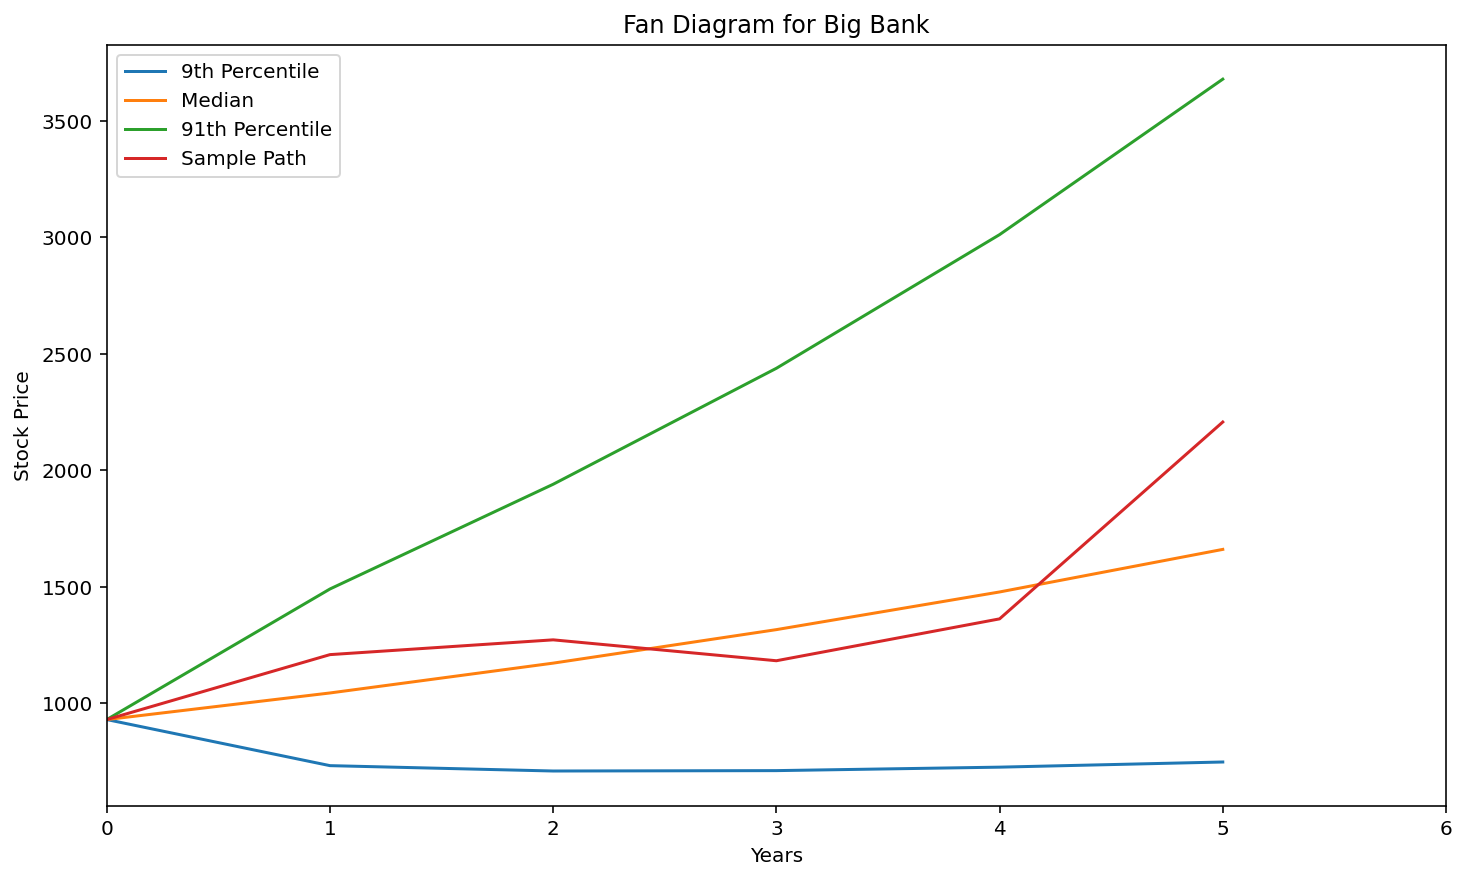

In [12]:
num_years = 5
n_scenarios = 10**6
n_steps = 52

simulated_S_T = simulate_S(final, m, Sigma, n_steps, n_scenarios, num_years)

big_bank = simulated_S_T[:, :, 1]

alpha = np.percentile(big_bank, 9, 0)
beta = np.percentile(big_bank, 50, 0)
gamma = np.percentile(big_bank, 91,0)

times = np.arange(num_years + 1)
plt.plot(times, alpha, label='9th Percentile')
plt.plot(times,beta, label='Median')
plt.plot(times, gamma, label='91th Percentile')

plt.plot(times,simulated_S_T[0,:, 1], label='Sample Path');
plt.xlim(0,6)
plt.title('Fan Diagram for Big Bank')
plt.xlabel('Years')
plt.ylabel('Stock Price')

plt.legend()
plt.show()

**Solution:** 4 _marks will be awarded for the quality of your plot._


What extra detail could you plot on this fan diagram to get a sense of the volatility?


**Solution:** *Insert the extra detail you would plot here.*



In [13]:
# Add a sample path of the Big Bank which can show the actual randomness of the price movement.

## Computing option prices

A European call option with strike $K$ and maturity $T$ on a stock is a derivative which gives a payout of $\max\{S_T-K,0\}$ at maturity, where $S_T$ is the price of the stock time $T$. A European put option with strike $K$ and maturity $T$ gives a payout of $\max\{K-S_T,0\}$ at maturity. In this section we are going to price these options using different methods.


### Analytic formula - Black-Scholes

We will begin by pricing them in the Black\-Scholes model. This consists of a stock following Geometric Brownian
$$
d S_t = \mu Sdt + \sigma S dW_t,
$$
where $\mu$ is called the drift, $\sigma$ is called the volatility and $W_t$ is a continuous time Wiener process, as well as a a risk-free asset that grows at a **constant continuously compounded per annum** interest rate $r \geq 0$, often interpreted as a bank account.

For a call option with strike $K$ and maturity $T$,
on a stock with price $S_0$ at time $0$, the Black\-Scholes price of the call option is computed using the formula
$$
\text{Call option price}=N(d_1)S_0 - Ke^{-rT}N(d_2)
$$
where
$$d_1 = \frac{1}{\sigma \sqrt{T}}\left( \log(S_0/K) + \left(r+\frac{\sigma^2}{2}\right)T\right)$$
and
$$d_2 = \frac{1}{\sigma \sqrt{T}}\left( \log(S_0/K) + \left(r-\frac{\sigma^2}{2}\right)T\right).$$Here $N$ is the cumulative distribution function of the standard normal distribution.

This formula will be explained later in the course. For now, you simply need to **write a Python function which can compute it**. Since
you do not yet know the theory used to derived this formula, **I have provided some tests** that you can use to check your have
implemented this formula correctly.  

Also write a function to compute a call payoff. 



In [14]:
# from topic 8 silde 13
import scipy.stats

def N(x):
    return scipy.stats.norm.cdf(x)

def d1_d2(S0, K, T, r, sigma):

    d1 = 1/(sigma*sqrt(T))*(log(S0/K) + (r+0.5*sigma**2)*T)
    d2 = d1 - sigma*sqrt(T)
    return d1,d2

def black_scholes_call_price(S0,K,T,r,sigma):
    d1, d2 = d1_d2(S0,K,T,r,sigma)
    return S0*N(d1) - exp(-r*(T))*K*N(d2)

In [15]:
def call_payoff(ST, K):
    return maximum(ST - K, 0.0)

In [16]:
np.testing.assert_almost_equal(black_scholes_call_price(100.0, 110.0, 1, 0.05, 0.2), 6.040, decimal=3)

The Black\-Scholes price formula for a European put option with strike $K$ and maturity $T$ is
$$e^{-rT} K N(-d_2) - N(-d_1) S_0.$$Write a function to compute this. Also write a function to compute a put payoff.


In [17]:
def black_scholes_put_price(S0,K,T,r,sigma):
    d1, d2 = d1_d2(S0, K, T, r, sigma)
    return np.exp(-r * T) * K * N(-d2) - S0 * N(-d1) # N(-x) = 1 - N(x)

In [18]:
def put_payoff(ST, K):
    return np.maximum(K - ST, 0.0)

In [19]:
np.testing.assert_almost_equal(black_scholes_put_price(100.0, 110.0, 1, 0.05, 0.2), 10.675, decimal=3)

In [20]:
#Self-test
# Put-call Parity: C - P = S0 - K * exp(-r*T)

S0 = 100.0
K = 110.0
T= 1
r = 0.05
sigma = 0.2

C = black_scholes_call_price(S0,K,T,r,sigma)
P = black_scholes_put_price(S0,K,T,r,sigma)

left = C-P
right = S0 - K * exp(-r*T)
assert abs(left - right) < 1e-6

# Volatility: Higher volatility means a wider distribution of terminal stock prices. Because of options have convexity, a wider distribution increases the expected value of the payoff in the risk-neutral measure. Therefore, a Call option with sigma=0.5 must be strictly more expensive than an a option with sigma=0.2
S0 = 100.0
K = 110.0
T= 1
r = 0.05
sigma_5 = 0.5

def test_bs_vol():
    C_5 = black_scholes_call_price(S0,K,T,r,sigma_5)
    assert C_5 > C
test_bs_vol()

### Monte Carlo pricing - Black-Scholes

The price of an option in the Black\-Scholes market can also be computed using Monte Carlo methods. Specifically, the price of the option is given by
$$
\text{Option Price} = e^{-rT}\mathbb{E}_{\mathbb{Q}}(\text{Option Payoff})\tag{*}.
$$That is, the option price today is the discounted expected value of the option payoff under a probability measure $\mathbb{Q}$. $\mathbb{Q}$ is called the risk neutral probability measure and is the continuous time analogue of the risk neutral probability measure $p^*$, we saw for the binomial model. All this means is stock price paths must be simulated as
$$
d S_t = rS dt +\sigma S dW_t, 
$$
rather than 
$$d S_t = \mu S dt +\sigma S dW_t.$$Again, this will be explained later in the course. For now, you simply need to simulate such stock price paths \(I have provided the inputs your `simulate_S` function needs to do this\) and compute the option price using \(\*\). The prices **should match those given by the analytic formulae above** \(to at least 1 decimal place\). This is because of the Feynman\-Kac Theorem which we will see in week 10. 

Write a function called `monte_carlo_pricer` that takes as input the number of stock price paths to generate, the initial stock price, continuously compounded per annum interest rate $r$, option maturity $T$, strike price $K$ and a variable called `option_type`, which is a string that can be either `'call'` or `'put'`. Your function should return the option price at time 0. 

Compute the price of a European call and put option for the details described below and store your answers in variables called `mc_call_price` and `mc_put_price` respectively.


In [21]:
question.describe_option()

* The strike is $K$=83.0
* The maturity is $T$=4.0
* The initial stock price is $S_0$=121.0
* The volatility is $\sigma$=0.13
* The continuously compounded interest rate is $r$=0.01


In [22]:
# simulate_S is in Question2
#St = S0 * exp((r - 0.5*sigma^2)t + sigma*Wt)
def monte_carlo_pricer(n_scenarios, S0, sigma, r, T, K, option_type):
    Z = np.random.randn(n_scenarios)
    drift = (r - 0.5 * sigma**2) * T
    diffusion = sigma * np.sqrt(T) * Z
    St = S0 * np.exp(drift + diffusion)
    if option_type == 'call':
        payoff = np.maximum(St-K, 0)
    elif option_type == 'put':
        payoff = np.maximum(K-St, 0)
    option_price = exp(-r*T)*np.mean(payoff)
    return option_price

n_scenarios = 10**6
K = 83.0
T = 4
S0 = 121.0
sigma = 0.13
r = 0.01
option_type = 'call'
mc_call_price = monte_carlo_pricer(n_scenarios, S0, sigma, r, T, K, option_type)

n_scenarios = 10**6
K = 83.0
T = 4
S0 = 121.0
sigma = 0.13
r = 0.01
option_type = 'put'
mc_put_price = monte_carlo_pricer(n_scenarios, S0, sigma, r, T, K, option_type)

In [23]:
#self-test
# because of the Feynman-Kac Theorem, the prices should match those given by the analytic formulae above (to at least 1 decimal place).
K = 83.0
T = 4
S0 = 121.0
sigma = 0.13
r = 0.01
C = black_scholes_call_price(S0,K,T,r,sigma)
P = black_scholes_put_price(S0,K,T,r,sigma)

assert abs(mc_call_price - C) < 0.1
assert abs(mc_put_price - P) <0.1

# Assume sigma → 0,  geometric brownian motion will become a simple exponential growth: St = S0*exp(r*T), therefore, the present value of option will become its discount of future option value.
n_scenarios = 1000
K = 83.0
T = 4
S0 = 121.0
sigma = 1e-6
r = 0.01
option_type = 'call'
def test_mc_limit():
    mc_test_price = monte_carlo_pricer(n_scenarios, S0, sigma, r, T, K, option_type)
    assert mc_test_price - (S0-K*np.exp(-r*T)) < 0.01
test_mc_limit()

### Binomial model pricing

We have seen how to price derivatives in the Binomial Model. Write a function called `binomial_pricer` which takes as parameters the strike price $K$, maturity $T$, initial stock price $S_0$, $u> 1$ representing the stock price upward movement, $d<1$ representing the stock price downward movement, **the discrete per annum interest rate** $r_d\geq 0$, the number of time steps `n_steps`, and a parameter called `option_type`, which is a string that can be either `call` or `put`. 

Your function should return the price of the derivative at time 0. You do not need to calculate the replicating strategy and since we are only pricing calls and puts, which are path independent derivatives, you only need to compute the stock price at the final time and the probabilities of getting there.

You may find it helpful to write $(1+ r_d/n_{steps})$ for the discount factor at each time step in your code.

I have provided tests that correspond to the following examples in week 2 of the course: first example in notebook 2 'Pricing Options', first question in notebook 3 'Exercises' and the the first example in notebook 4 'More Complex Examples'.


In [24]:
def binomial_pricer(K, T, S0, r, u, d, n_steps, option_type='call'):
    dt = T / n_steps
    R = 1 + r * dt # according to E-mail
    discount = 1.0 / R
    p = (R - d) / (u - d)
    
    values = []
    
    for i in range(n_steps + 1):
        St = S0 * (u ** i) * (d ** (n_steps - i))
        if option_type == 'call':
            payoff = max(St - K, 0.0)
        elif option_type == 'put':
            payoff = max(K - St, 0.0)
        else:
            return None
        values.append(payoff)
 
    for step in range(n_steps - 1, -1, -1):
        past_values = []
        for i in range(step + 1):
            value_up = values[i+1]
            value_down = values[i]
            expected_values = p * value_up + (1 - p) * value_down
            present_values = discount * expected_values
            past_values.append(present_values)

        values = past_values

    return values[0]

In [25]:
np.testing.assert_almost_equal(binomial_pricer(K=100.0, T=1, S0=100.0, r=0.0, u=1.01, d=0.99, n_steps=1, option_type='call'), 0.5, decimal=2)
np.testing.assert_almost_equal(binomial_pricer(K=250.0, T=1, S0=240.0, r=0.03, u=1.1, d=0.95, n_steps=1, option_type='put'), 9.97, decimal=2)
np.testing.assert_almost_equal(binomial_pricer(K=100.0, T=2, S0=100.0, r=0.02, u=1.05, d=0.95, n_steps=2, option_type='call'), 4.83, decimal=2)

Now let the up and down movements of the stock be given by the expressions
$$
u = e^{\sigma \sqrt{dt}} \text{ and } d = e^{-\sigma \sqrt{dt}}.
$$Compute the price of a European call and put with the same details as in the Monte Carlo pricing question, but in the binomial model using your `binomial_pricer` function with 1 time step. Store them in variables called `call_price_1` and `put_price_1`.


In [26]:
K = 83.0
T = 4
S0 = 121.0
sigma = 0.13
r = 0.01
n_steps = 1
dt = T / n_steps
u = np.exp(sigma*np.sqrt(dt))
d = np.exp(-sigma*np.sqrt(dt))

call_price_1 = binomial_pricer(K, T, S0, r, u, d, n_steps, option_type='call')
call_price_1

put_price_1 = binomial_pricer(K, T, S0, r, u, d, n_steps, option_type='put')
put_price_1

0.0

In [27]:
#Self-test:
# put call parity
def test_binomial_pricer():
    left = call_price_1-put_price_1
    right = S0 - K * exp(-r*T)
    assert abs(left - right) < 0.1
    
test_binomial_pricer()

# For call option, theo value of option which has lower strike price, will more expensive than the value of option which has higher strike price. Therefore, we can test two options that are same except for their strike price and verify that the option value with higher strike price is lower than the option value with lower strike price.

def test_b_strike():
    K_100 = 100
    call_price_test = binomial_pricer(K_100, T, S0, r, u, d, n_steps, option_type='call')
    assert call_price_test < call_price_1
    
test_b_strike()

Now compute the prices with 10 time steps, 100 time steps and 1000 time steps, storing them in the variables `put_price_10`,  `call_price_10`, `put_price_100`,  `call_price_100`, `put_price_1000` and  `call_price_1000` respectively.



In [28]:
n_steps = 10
put_price_10 = binomial_pricer(K, T, S0, r, u, d, n_steps, option_type='put')
call_price_10 = binomial_pricer(K, T, S0, r, u, d, n_steps, option_type='call')
print(put_price_10)
print(call_price_10)

n_steps = 100
put_price_100 = binomial_pricer(K, T, S0, r, u, d, n_steps, option_type='put')
call_price_100 = binomial_pricer(K, T, S0, r, u, d, n_steps, option_type='call')
print(put_price_100)
print(call_price_100)

n_steps = 1000
put_price_1000 = binomial_pricer(K, T, S0, r, u, d, n_steps, option_type='put')
call_price_1000 = binomial_pricer(K, T, S0, r, u, d, n_steps, option_type='call')
print(put_price_1000)
print(call_price_1000)

15.501055750350478
56.74916936649832
60.88134037564208
102.13517912933328


79.74163407175205
120.99604682736931


What do you observe about the two prices as the number of time steps increases? From this, does the Binomial model appear to converge to something as the number of steps approaches infinity, and if so, what is the limit?


**Solution:** Insert _your answer here._


In [29]:
# the two prices are increasing, accompanied with the time. Probably converge to the analytical solution of BS model

### Put-Call Parity

In this question we have studied how to price European call and puts using different methods. There is actually a connection between the price of a call and put which have the same strike price $K$, which means once you have computed the price of one, the other is automatically determined. This is known as put-call parity and it is given by the formula
$$
C + Ke^{-rT} = P + S_0,
$$where $C$ and $P$ are the price of the call and put at time $t=0$ respectively, $r$ is the continuously compounded interest rate, $T$ is the maturity of the option and $S_0$ is the price of the stock at time 0. Why this is true can be understood by looking at the payoff of the portfolios on each side of the equation. 

Case 1: At time $T$, if $S_T>K$ then the call pays out $S_T-K$ and the bond is worth $K$ making the value of the portfolio on left hand side $S_T$, while on the right hand side, the put is worthless and the stock is worth $S_T$.

Case 2: At time $T$, if $S_T<K$ then the call is worthless and the bond is worth $K$, while on the right hand side, the put pays out $K-S_T$ and the stock is worth $S_T$ making the value of the portfolio on the right hand side $K$.

Consider the values of $S_0$, $\sigma$, $r$, $K$ and $T$ used in the last two questions. Verify numerically that put call parity holds for all three methods we have used for pricing European calls and puts. You should demonstrate this by writing tests.


In [30]:
def put_call_parity(C, P, S0, K, r, T):
    left = C + K * np.exp(-r*T)
    right = P + S0
    parity = left - right
    assert abs(parity) < 0.1
    print(f'put call parity holds')
    return

In [31]:
# Self-test:
K = 83.0
T = 4
S0 = 121.0
sigma = 0.13
r = 0.01

#1 BS

C = black_scholes_call_price(S0,K,T,r,sigma)
P = black_scholes_put_price(S0,K,T,r,sigma)

parity_BS = put_call_parity(C, P, S0, K, r, T)

#2 Monte carlo
n_scenarios = 1000000
option_type = 'call'
C = monte_carlo_pricer(n_scenarios, S0, sigma, r, T, K, option_type)

n_scenarios = 1000000
option_type = 'put'
P = monte_carlo_pricer(n_scenarios, S0, sigma, r, T, K, option_type)
parity_Mc = put_call_parity(C, P, S0, K, r, T)

#3 Binomial tree

n_steps = 1000
dt = T / n_steps
u = np.exp(sigma*np.sqrt(dt))
d = np.exp(-sigma*np.sqrt(dt))

C = binomial_pricer(K, T, S0, r, u, d, n_steps, option_type='call')
P = binomial_pricer(K, T, S0, r, u, d, n_steps, option_type='put')
parity_Bt = put_call_parity(C, P, S0, K, r, T)

put call parity holds


put call parity holds


put call parity holds


If put call parity did not hold, what would this imply about the market?



**Solution:** _Insert your answer here._



Self\-test:

If put call parity did not hold, the opportunity of arbitrage may exist in the market. For example, if C \+ Ke\(−rT\) &lt; P\+S0, people can buy the call option and risk free assets and the sell put option and stocks. Therefore, people can earn a risk free profit which violates the principle of the BS model.

​



## Testing your code

Your code will be tested as part of the marking process. However, you should also write your own tests and explain how they work.
The better your tests, the higher your mark will be. For each test that you write, provide a mathematical description of the test as well
as the code that performs the test.


**Solution:** _Describe the tests you have performed here._


Self\-test are provided beneath each question.
